In [1]:
import numpy as np
import pandas as pd 
import chardet
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#checking the encoding style of the input csv file.By mentioning the encoding style in read_csv(), we can avoid the chances of getting an error due to encoding style mismatch 
with open('spam.csv', 'rb') as rawdata:
    encode_style =  chardet.detect(rawdata.read(100000))
print(encode_style)

{'encoding': 'Windows-1252', 'confidence': 0.7270322499829184, 'language': ''}


In [3]:
data = pd.read_csv('spam.csv',encoding='Windows-1252')

In [4]:
# checking the data information 
# the last 3 column (Unnamed: 2, Unnamed: 3, Unnamed: 4) has maximum null values.To confirm the same, another checking using isnull() will be done
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [5]:
# there is no missing values in first two column but maximum values are missing in the last 3 columns. So, we will drop these last 3 columns 
data.isnull().sum()


v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

In [6]:
#dropping the last 3 columns
data.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1,inplace=True)

In [7]:
# To increase the readbility , lets change the column name of first two column (v1 and v2)
data.columns = ['Label','Message']
#checking the data 
data.head(3)

,Label,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...


In [8]:
# To understand the details information of these two column. 
data.describe()

,Label,Message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [9]:
#creating a new column to understand the charactertistics of two type message label 
data['Message_length'] = data['Message'].apply(len)

In [10]:
# checking the distribution of message size
data.groupby('Label')['Message_length'].describe()

,count,mean,std,min,25%,50%,75%,max
Label,,,,,,,,
ham,4825.0,71.023627,58.016023,2.0,33.0,52.0,92.0,910.0
spam,747.0,138.866131,29.183082,13.0,132.5,149.0,157.0,224.0


The mean length of spam messages are larger than the mean length of the ham messages. Usually, the length of the spam messages are larger in length of the non-spam messages. To verify it again,we will check the the distribution plots

Text(0, 0.5, 'Freequency')

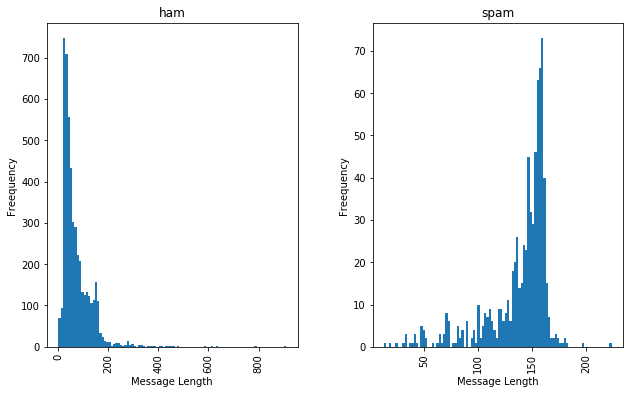

In [11]:
dist_message = data['Message_length'].hist(bins=100,by=data['Label'],figsize=(10,6))
dist_message[0].set_xlabel("Message Length")
dist_message[0].set_ylabel("Freequency")
dist_message[1].set_xlabel("Message Length")
dist_message[1].set_ylabel("Freequency")

From this basic EDA it is clear that the spam messages are larger in length. In message label = ham distrbution, there is a message whose length is much higher than the other messages in ham group. Now, it is difficult to get the actual length of this long message from this plot. From the output of our previous data.groupby('Label')['Message_length'].describe(), we can see that the max length is 910. Now, we can also check which message is this in ham group.



In [12]:
# To find out the message which has a length of 910 
data[data['Message_length'] == 910]['Message'].iloc[0]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

# Data pre-processing

In [13]:
import string
from nltk.corpus import stopwords

In [14]:
def text_clean(message):
    
    # removing all punctuation
    nopunc = [letter for letter in message if letter not in string.punctuation]
    punc_filtered = "".join(nopunc)
    # removing all stopwords
    return [words for words in punc_filtered.split(" ") if words.lower() not in stopwords.words('english')]
    # returning the words as list 

As an example,we can see how this text_clean() works on messages :


In [15]:
data['Message'].apply(text_clean)

0       [Go, jurong, point, crazy, Available, bugis, n...
1                          [Ok, lar, Joking, wif, u, oni]
2       [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3           [U, dun, say, early, hor, U, c, already, say]
4       [Nah, dont, think, goes, usf, lives, around, t...
                              ...                        
5567    [2nd, time, tried, 2, contact, u, U, å£750, Po...
5568                   [Ì, b, going, esplanade, fr, home]
5569                   [Pity, , mood, Soany, suggestions]
5570    [guy, bitching, acted, like, id, interested, b...
5571                                   [Rofl, true, name]
Name: Message, Length: 5572, dtype: object

Before performing Vectorization, we will divide the dataset into training and test set to avoid Data leakage. Once these partitions are done,  each of these sets(training and test set) will be converted into vectors

In [16]:
from sklearn.model_selection import train_test_split

Here, we are using only the 'Message' column to perform the classfication and we are taking 70% of dataset as training data and the remainder 30% as test set.

In [17]:
x_Train,x_Test,y_Train,y_Test = train_test_split(data['Message'],data['Label'],test_size=0.3)

# Vectorization

In [18]:
from sklearn.feature_extraction.text import CountVectorizer

In [19]:
train_bow = CountVectorizer(analyzer=text_clean).fit(x_Train)

In [20]:
# total number of vocab words
print(len(train_bow.vocabulary_))

9200


In [21]:
# to see the entire vocabulary
#train_bow.vocabulary_   # execute this command to see the entire vocabulary and the index position of each word

In [22]:
#transforming the entire training data set messages:
train_matrix = train_bow.transform(x_Train)

In [23]:
print('Shape of Sparse Matrix: ', train_matrix.shape)
print('Amount of Non-Zero occurences: ', train_matrix.nnz)

Shape of Sparse Matrix:  (3900, 9200)
Amount of Non-Zero occurences:  35928


To assign a weight to each word of the vocabulary, we will use TF-IDF. The words which has higher freequency will be assigned a lower weighatge and the words which are rare and has lower freequency will be assigned a higher weighatge.

In [24]:
from sklearn.feature_extraction.text import TfidfTransformer
tf_idf_train = TfidfTransformer().fit(train_matrix)
messages_tf_idf_train = tf_idf_train.transform(train_matrix)

To confirm that the word with higher freequency has given a lower weightage than the word with lower freequency, we can consider two word from the entire document- 'want' and 'come'(more freequent)

In [25]:
print(tf_idf_train.idf_[train_bow.vocabulary_['want']])
print(tf_idf_train.idf_[train_bow.vocabulary_['come']])

4.5240560811434065
4.292254467086082


as the word 'come' is more frequent than 'want' in the entire dataframe, it receives lower weightage

In [26]:
test_matrix = train_bow.transform(x_Test)
tf_idf_test = TfidfTransformer().fit(test_matrix)
messages_tf_idf_test = tf_idf_test.transform(test_matrix)

Here two scikit-learn models will be used: Naive Bayes and KNN. The accuracy of these models will be compared


# Naive Bayes

In [27]:
from sklearn.naive_bayes import MultinomialNB

In [28]:
nb = MultinomialNB()
nb.fit(messages_tf_idf_train,y_Train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [29]:
y_pred = nb.predict(messages_tf_idf_test)

In [30]:
from sklearn.metrics import classification_report,accuracy_score
print("Classification report is: ")
print(classification_report(y_Test,y_pred))
print("Accuracy Score of Naive Bayes model is: ")
print(round(accuracy_score(y_Test,y_pred),3))

Classification report is: 
              precision    recall  f1-score   support

         ham       0.95      1.00      0.98      1443
        spam       1.00      0.69      0.82       229

    accuracy                           0.96      1672
   macro avg       0.98      0.85      0.90      1672
weighted avg       0.96      0.96      0.95      1672

Accuracy Score of Naive Bayes model is: 
0.958


# KNN:

GridSearchCV can be used to identify the best value of k for KNN model. But instead of using GridSearchCv, we can also estimate the best value of K in the following way:

assuming that the best value of K lies in between 1 to 40. we are creating an instance of KNN here and trying to mesaure the prediction error made by that instance of KNN.



In [31]:
from sklearn.neighbors import KNeighborsClassifier

In [32]:
error_rate = []
for i in range(1,40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(messages_tf_idf_train,y_Train)
    y_pred_elbow = knn.predict(messages_tf_idf_test)
    error = np.mean((y_Test != y_pred_elbow))
    error_rate.append(error)

Text(0, 0.5, 'Error Rate')

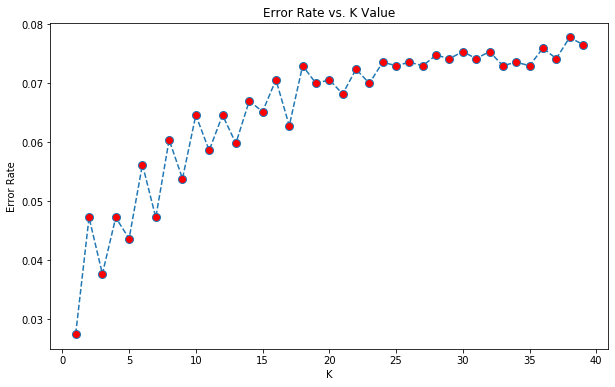

In [33]:
plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,linestyle='--',marker='o',markersize=8,markerfacecolor='red')
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

From the above plot, it is clear that the error rate is increaseing after K=5. The minimum error that we can get in this task is for k=3 or k=5. The error rate for k=4 will be higher than k=3 or k=5. We will check the performance for these two k value.

In [34]:
#k=3
knn_3 = KNeighborsClassifier(n_neighbors=3)
knn_3.fit(messages_tf_idf_train,y_Train)
y_pred = knn_3.predict(messages_tf_idf_test)
print("Classification report is: ")
print(classification_report(y_Test,y_pred))
print("Accuracy Score of KNN(K=3): ")
print(round(accuracy_score(y_Test,y_pred),3))

Classification report is: 
              precision    recall  f1-score   support

         ham       0.96      1.00      0.98      1443
        spam       0.97      0.75      0.85       229

    accuracy                           0.96      1672
   macro avg       0.96      0.87      0.91      1672
weighted avg       0.96      0.96      0.96      1672

Accuracy Score of KNN(K=3): 
0.962


In [35]:
#K=4 

knn_4 = KNeighborsClassifier(n_neighbors=4)
knn_4.fit(messages_tf_idf_train,y_Train)
y_pred = knn_4.predict(messages_tf_idf_test)
print("Classification report is: ")
print(classification_report(y_Test,y_pred))
print("Accuracy Score of KNN(K=4): ")
print(round(accuracy_score(y_Test,y_pred),3))

Classification report is: 
              precision    recall  f1-score   support

         ham       0.95      1.00      0.97      1443
        spam       0.97      0.67      0.80       229

    accuracy                           0.95      1672
   macro avg       0.96      0.83      0.88      1672
weighted avg       0.95      0.95      0.95      1672

Accuracy Score of KNN(K=4): 
0.953


In [36]:
#K=5
knn_5 = KNeighborsClassifier(n_neighbors=5)
knn_5.fit(messages_tf_idf_train,y_Train)
y_pred = knn_5.predict(messages_tf_idf_test)
print("Classification report is: ")
print(classification_report(y_Test,y_pred))
print("Accuracy Score of KNN(K=4): ")
print(round(accuracy_score(y_Test,y_pred),3))

Classification report is: 
              precision    recall  f1-score   support

         ham       0.96      1.00      0.98      1443
        spam       0.96      0.71      0.82       229

    accuracy                           0.96      1672
   macro avg       0.96      0.85      0.90      1672
weighted avg       0.96      0.96      0.95      1672

Accuracy Score of KNN(K=4): 
0.956


The accuracy score of K=4 is lower than the K=3 or K=5 ( as it is visible already in the error-rate vs K plot). Between K=3 and K=5, K=3 will be a good choice interms of model accuracy

In [37]:
data.shape

(5572, 3)